# Proyecto Visión por computadora
### Agrupamiento de imágenes por medio del contorno de estas

#### Estudiantes:

Luisa Fernández Madrid

David Estepa Ruiz cc: 1017257444

#### Justificación del problema

En el campo de la biología la clasificación de nuevas especies es una tarea que se realiza a diario, siendo una de las características que se toman en cuenta para esta tarea la morfología de la especie en cuestión. En este caso se pretende agrupar un conjunto de imágenes pertenecientes a diferentes hojas de árboles, esto con el fin de mostrar cómo las diferentes herramientas de Machine Learning pueden comenzar a tener cabida en el campo de la taxonomía. 

##### Procesamiento de la imagen

En las siguientes lineas de código se mostrará los pasos que se le debieron hacer a todas las imágenes tomadas de las hojas. De manera que solo se tuviera el contorno de estas. Esto se muestra solo a una imagen, sin embargo, el conjunto de imagenes usados para clasificar fueron tomados de una base de datos de Internet.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img0=cv2.imread('Hoja_hortensia.jpg')
img=cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

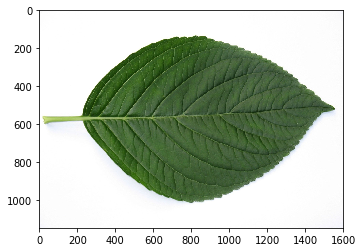

In [2]:
plt.imshow(img)

In [3]:
#calculo de un mejor umbral
media=np.mean(img)
desvS=np.std(img)
print(media, desvS)

176.43528987176032 91.6995596158764


In [4]:
pcm=media+(desvS/2)

222.0


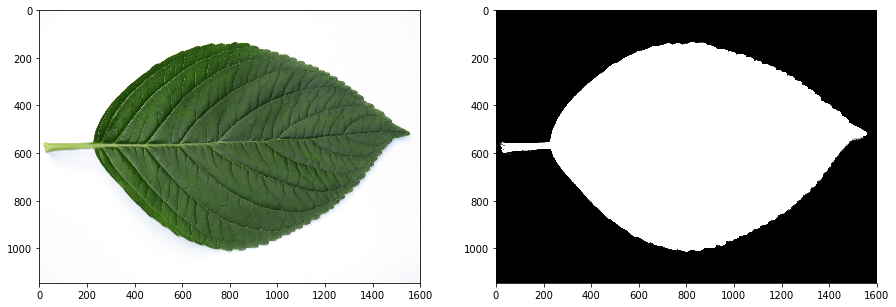

In [5]:
Umb,imgC=cv2.threshold(img,pcm,255,cv2.THRESH_BINARY_INV)
print (Umb)
imgD= imgC
imgD=cv2.cvtColor(imgC,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgD, cmap='gray')

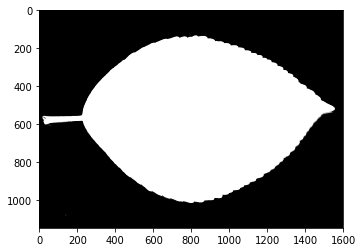

In [6]:
R1=cv2.GaussianBlur(imgD,(5,5),cv2.BORDER_DEFAULT)

plt.imshow(R1, cmap='gray')

##### Procesamiento de los datos por agrupar

El algoritmo de Kmeans ofrecido por scikitLearn acepta un arreglo bidimensional donde, en el caso de ser una imagen, cada fila equivale a una muestra a clasificar, y cada columna a una característica de la imagen. La característica es la intensidad del pixel en determinada posicion, esta posicion debe ser compartida por todas las imagenes por agrupar, por lo que la dimension de cada imagen debe ser la misma.

Para esto entonces se realiza un procesamiento antes de utilizar el modelo, ya que las imágenes no tienen la misma dimensión. Además de lo anterior se debe tener en cuenta los datos que se ingresarán al modelo, ya que puede que el modelo no sea capaz de soportar muchas características (muchos pixeles).

In [7]:
import matplotlib
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import rescale

In [8]:
#%% preprocesamiento de Imagenes
#Carga de Imagenes
numImage = 1584

shapesMatrix = np.zeros((2,numImage))
listImas = []
for k in range(numImage):
    imageFilename = 'images/' + str(k+1) + '.jpg'
    currImage = mpimg.imread(imageFilename)
    shapesMatrix[:,k] = np.shape(currImage)
    listImas.append(currImage)

In [9]:
#Se establece las dimensiones que tendran todas las imagenes, se garantiza que sean un numero impar para tener un centro
maxShapeSize = shapesMatrix.max(axis=1)
for k in range(len(maxShapeSize)):
    if maxShapeSize[k] % 2 == 0:
        maxShapeSize[k] += 311
    else:
        maxShapeSize[k] += 310

In [10]:
DimMatriz3D=np.hstack((maxShapeSize, np.shape(shapesMatrix[1]))).astype(int)
ImaGrandeXc = (maxShapeSize[1]+1)/2; ImaGrandeYc = (maxShapeSize[0]+1)/2 #Centros de la matriz grande donde se centran las imagenes

fullImageMatrix3D = np.zeros(DimMatriz3D,dtype=np.dtype('u1'))

#Se llena la
for k, currImage in enumerate(listImas):
    Yc, Xc = ndi.center_of_mass(currImage)
    Xd = ImaGrandeXc - Xc; Yd = ImaGrandeYc - Yc
    rowIndLims = (int(round(Yd)),int(round(Yd)+np.shape(currImage)[0]))
    colIndLims = (int(round(Xd)),int(round(Xd)+np.shape(currImage)[1]))
    fullImageMatrix3D[rowIndLims[0]:rowIndLims[1],colIndLims[0]:colIndLims[1],k] = currImage
    
print('Dimension de matriz luego de agrupar las imagenes: ',fullImageMatrix3D.shape)

Dimension de matriz luego de agrupar las imagenes:  (1399, 2017, 1584)


(-0.5, 2016.5, 1398.5, -0.5)

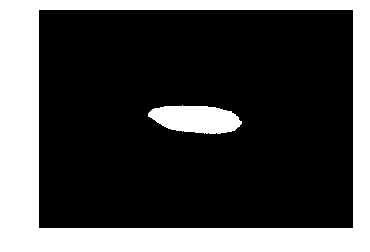

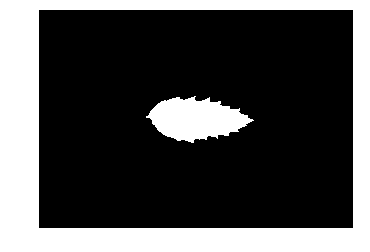

In [11]:
#Muestra de que quedaron centradas 
plt.figure()
plt.imshow(fullImageMatrix3D[:,:,1],cmap='gray')
plt.axis('off')
plt.figure()
plt.imshow(fullImageMatrix3D[:,:,6],cmap='gray')
plt.axis('off')

Debido a que hay demasiados pixeles en las imágenes es necesario remover las filas y columnas llenas de ceros, y disminuir el tamaño de la imagen por medio de la funcion rescale que ofrece ScikitLearn. Este método interpola valores, de manera que la imagen resultante es una aproximación de la imagen real.

In [12]:
#Recorte de filas y columnas que comparten valores de cero
xValid = fullImageMatrix3D.mean(axis=2).sum(axis=0) > 0
yValid = fullImageMatrix3D.mean(axis=2).sum(axis=1) > 0
xLims = (np.nonzero(xValid)[0][0],np.nonzero(xValid)[0][-1])
yLims = (np.nonzero(yValid)[0][0],np.nonzero(yValid)[0][-1])
fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1],xLims[0]:xLims[1],:]

        
# Disminucion del tamaño de la matriz
rescaleFactor = 0.15

scaledDownImage = rescale(fullImageMatrix3D[:,:,0],rescaleFactor)
scaledDownImages = np.zeros(np.hstack((np.shape(scaledDownImage),
                                       np.shape(fullImageMatrix3D)[2])),dtype=np.dtype('f4'))
for imInd in range(np.shape(fullImageMatrix3D)[2]):
    scaledDownImages[:,:,imInd] = rescale(fullImageMatrix3D[:,:,imInd],rescaleFactor)

C:\Users\david\Anaconda3\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\david\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\david\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [13]:
print('Dimension de matriz luego de recortar datos en cero: ',fullImageMatrix3D.shape)

Dimension de matriz luego de recortar datos en cero:  (1131, 1664, 1584)


In [14]:
print('Dimension de matriz luego de ser escalada para disminuir su dimension: ',scaledDownImages.shape)
x1,y1,z1=scaledDownImages.shape
ProcesamientofullImageMatrix3D=scaledDownImages.reshape((x1*y1,z1))
ProcesamientofullImageMatrix3D=np.transpose(ProcesamientofullImageMatrix3D)
ProcesamientofullImageMatrix3D.shape

Dimension de matriz luego de ser escalada para disminuir su dimension:  (170, 250, 1584)


(1584, 42500)

Luego de tener una dimension adecuada para los datos que ingresarán al modelo, se procede entonces a la implementación de este.

##### Entrenamiento del Modelo y Agrupamiento

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(ProcesamientofullImageMatrix3D)
kmeans.cluster_centers_.shape

(10, 42500)

Cuando se entrena el modeol con el método .fit_predict, este retorna los datos agrupados con una etiqueta. A su vez, se muestra la dimensión de los centros. Siendo estos 10 (Elegidos) y cada uno determinado por 42500 características, o en este caso, pixeles. Por lo tanto, como estos están ubicados en un espacio de pixeles es posible observar estos qué información tienen:

In [16]:
centers = kmeans.cluster_centers_.reshape(10, x1, y1)

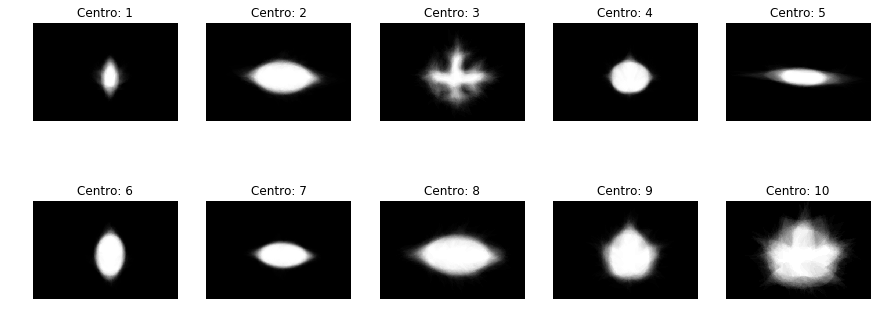

In [17]:
plt.figure(figsize=(15,6))
cont=1
for fig in range(10):
    plt.subplot(2,5,fig+1)
    plt.imshow(centers[fig], cmap='gray')
    plt.axis('off')
    plt.title('Centro: '+str(fig+1))
plt.show()

En la anterior imagen se puede observar cómo los centros comienzan a emular el contorno de algunas hojas, siendo algunos centros la aparente superposición de algunas imágenes, y otros estando aparentemente bien definidos.

Ahora bien, si se analiza la variable clusters, la cual contiene lo que retorna el método .fit_predict, se encuentra que esta contiene la información sobre a qué grupo está asociada cada imagen, permitiendo entonces plantear una distribución de las imagenes en funcion de los centros o grupos que hay:

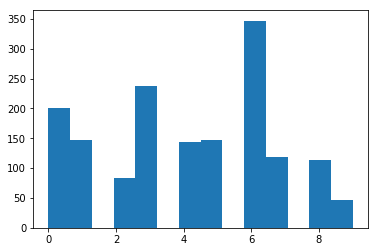

In [18]:
plt.hist(clusters,bins='auto')
plt.show()

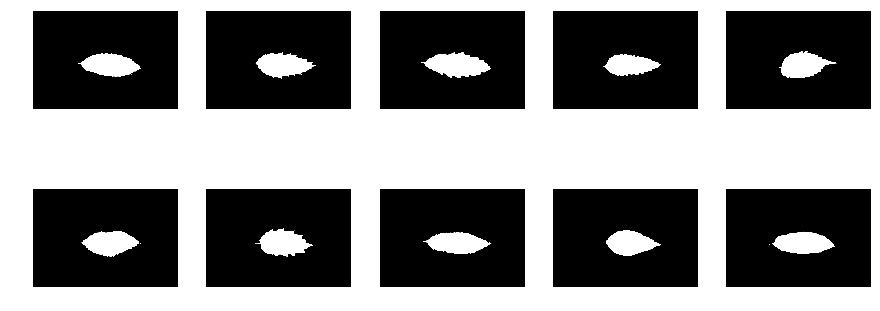

In [19]:
#Primeras 10 imagenes asociadas al centro 7
Img_Clust6=ProcesamientofullImageMatrix3D[clusters==6,:]
Img_Clust6=Img_Clust6.reshape(347, x1, y1);
plt.figure(figsize=(15,6))
for fig in range(10):
    plt.subplot(2,5,fig+1)
    plt.imshow(Img_Clust6[fig,:,:], cmap='gray')
    plt.axis('off')
plt.show()

Mediante el gráfico del histograma se encontró que el centro qué tiene más imágenes asociadas es el 7, por lo que se decide graficar las 10 primeras imágenes que están ubicadas en este grupo para observar si presentan algún patró que permite asociarlas a este grupo.

###### Análisis

De la gráfica de los centros se encuentra que posiblemente hayan más grupos en los que se pueden clasificar las imágenes, esto porque algunos centros parecen estar formados por la superposición de 2 o más imágenes. El problema en estos casos es el posible desempeño del algoritmo, ya que cuando se estaba entrenando el modelo, y realizando la reducción de dimensión en las imágenes que se agruparían, se encontró que el programa se demoraba en terminar su ejecución, esto posiblemente por la cantidad de datos que se tenían que procesar. Esto último representaría entonces un posible inconveniente si se deseara evaluar más posibles centros que pudieran agrupar de mejor manera el grupo de imágenes ingresadas.

Como estrategia para contrarrestar la demora en la ejecución del algoritmo se podrían evaluar otras librerías que permitan el uso de algoritmos de Machine Learning, como lo podría ser TensorFlow.

Cabe resaltar que la eficacia de un algoritmo de aprendizaje de máquina depende bastante de la calidad de los datos que se utilicen este, por lo que la fase de adquisición de los datos y su posterior procesamiento es de vital importancia. Ocacionando entonces una necesidad imperativa de que se realice un buen procesamiento de cada imagen, seleccionando las características de esta que se desean evaluar, y encotrando la manera de "esconder" las otras que no sean relevantes.